In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, f, shapiro, norm
from statsmodels.stats.stattools import durbin_watson

In [ ]:
df = pd.read_csv('data.csv', decimal=',')
df

,<TICKER>,<PER>,<DATE>,<TIME>,<CLOSE>
0,AFLT,D,250104,0,58.13
1,AFLT,D,250107,0,58.99
2,AFLT,D,250109,0,59.65
3,AFLT,D,250110,0,58.43
4,AFLT,D,250111,0,60.99
...,...,...,...,...,...
65,AFLT,D,250331,0,66.45
66,AFLT,D,250401,0,69.63
67,AFLT,D,250402,0,66.02
68,AFLT,D,250403,0,67.43


In [ ]:
# цены закрытия 01.01.2025-31.03.2025
train_Y = df['<CLOSE>'][0: -4].astype(float).to_numpy()
train_X = pd.Series([i for i in range(1, len(train_Y) + 1)]).to_numpy()

# цены закрытия 01.04.2025-04.04.2025
test_Y = df['<CLOSE>'][-4: ].astype(float).to_numpy()
test_X = pd.Series([i for i in range(len(train_Y) + 1, len(train_Y) + 5)]).to_numpy()

**1. Построение линейной регрессионной модели с гармонической составляющей:**

$$y(t) = a_0 + a_1 t + \sum_{k=1}^m \left(b_k \cos(\omega_k t) + c_k \sin(\omega_k t)\right)$$

где:
- $y(t)$ — цена закрытия в день $t$;
- $\omega_k$ — частоты значимых гармонических составляющих, определяемые спектральным анализом;
- $a_0, a_1, b_k, c_k$ — оценки МНК-параметров.

1) Проведем регрессионный анализ соответствующей линейной модели для нахождения остатков

Нахождение вектора оценок параметров регрессии:
$$
\hat{B} = K^{-1}Z,
$$

где:

$$
K = X^TX, \quad Z = X^TY,
$$

$$
X =
\begin{pmatrix}
1 & x_1^{(1)} & \cdots & x_k^{(1)} \\
1 & x_1^{(2)} & \cdots & x_k^{(2)} \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_1^{(n)} & \cdots & x_k^{(n)}
\end{pmatrix}
=
\begin{pmatrix}
1 & \varphi_1(x_1) & \cdots & \varphi_k(x_1) \\
1 & \varphi_1(x_2) & \cdots & \varphi_k(x_2) \\
\vdots & \vdots & \ddots & \vdots \\
1 & \varphi_1(x_n) & \cdots & \varphi_k(x_n)
\end{pmatrix}, \quad
Y =
\begin{pmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{pmatrix}
$$

In [ ]:
# Функция для нахождения оценки параметров уравнения линейной регрессии
def linear_reg_params(X, Y):
  n = len(X)
  X_lin = np.ones((n, 2))
  for i in range(n):
    X_lin[i][1] = X[i]
  K_lin = X_lin.T @ X_lin
  Z_lin = X_lin.T @ Y
  B_lin = np.linalg.inv(K_lin) @ Z_lin
  return B_lin, K_lin

# Вектор оценок параметров уравнения линейной регрессии
B_lin, K_lin = linear_reg_params(train_X, train_Y)

In [ ]:
# Примечание: расчет характеристик модели (R-квадрат и т. д.) будет далее автоматизирован.
# Поэтому любая модель будет представлена в виде функции с названием y_model.
# Названия параметров будут записываться в список ниже
y_model = lambda x, B: B[0] + B[1]*x
par_labels = ['a0', 'a1']

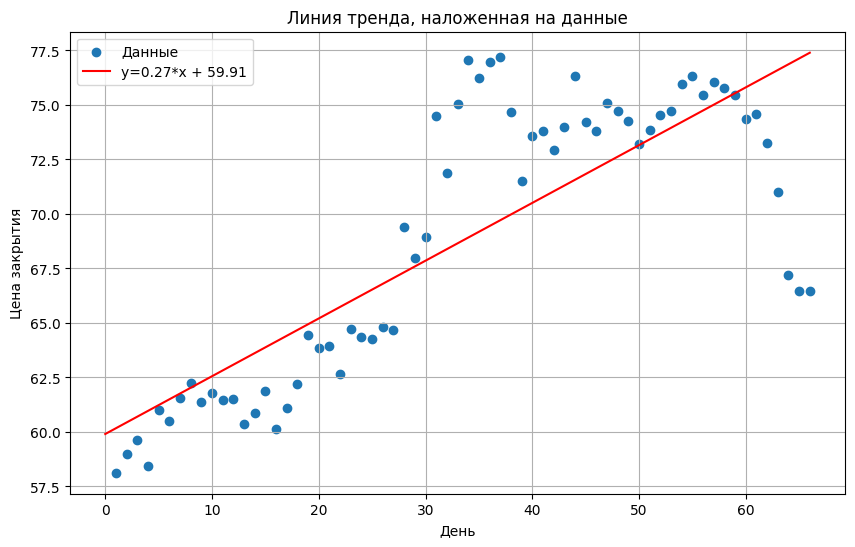

In [ ]:
# Изображение данных на графике
plt.figure(figsize=(10, 6))
plt.scatter(train_X, train_Y, label='Данные')
plt.title('Линия тренда, наложенная на данные')
plt.xlabel('День')
plt.ylabel('Цена закрытия')
plt.grid(True)
# Построение прямой линейной регрессии на графике
x = np.linspace(0, len(train_X))
y_line = y_model(x, B_lin)
plt.plot(x, y_line, 'r-', label=f'y={round(B_lin[1], 2)}*x + {round(B_lin[0], 2)}')
plt.legend()

Реализуем функцию, которая сразу будет вычислять для принимаемой на вход модели:
- коэффициент детерминации R²;
- F-статистику Фишера;
- уровень значимости для параметров модели;
- остаточную дисперсию.

Оценка коэффициента детерминации:
$$
\hat{R}^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}(x_i))^2}{\sum_{i=1}^n (y_i - \bar{y})^2}
$$


Cтатистика Фишера:
$$
F = \frac{n - k - 1}{k} \frac{\sum_{i=1}^{n} (\hat{y}(x_i) - \bar{y})^2}{\sum_{i=1}^{n} (\hat{y}(x_i) - y_i)^2} = \frac{n - k - 1}{k} \frac{\hat{R}^2}{1 - \hat{R}^2}
$$

Оценка остаточной дисперсии модели регрессии (несмещенная оценка дисперсии $ \sigma^2 $):

$$
s^2 = \frac{1}{n - k - 1} \sum_{i=1}^n (y_i - \hat{y}(x_i))^2
$$

Статистика Стьюдента

Для проверки значимости коэффициентов $\beta_j, j = 1, k$:

$t_j = \frac{\hat{\beta}_j}{\sqrt{s^2 [K^{-1}]_{jj}}}$, где $[K^{-1}]_{jj}$ - соответствующий диагональный элемент матрицы $K^{-1}$.

In [ ]:
def model_info(train_X, train_Y, B, K):
  # Вектор остатков модели
  res_vec = [train_Y[i] - y_model(train_X[i], B) for i in range(len(train_Y))]
  # Оценка коэффициента детерминации
  est_coef_det = 1 - (sum([res**2 for res in res_vec]))/(sum([(train_Y[i] - sum(train_Y)/len(train_Y))**2 for i in range(len(train_Y))]))
  # Статистика Фишера
  k = len(B) - 1
  n = len(train_Y)
  F = ((n-k-1)/k)*(est_coef_det/(1-est_coef_det))
  # Оценка остаточной дисперсии
  res_var_square = (1/(n-k-1))*(sum([res**2 for res in res_vec]))
  # Статистики Стьюдента для параметров модели
  t_vec = [B[j]/(res_var_square*(np.linalg.inv(K))[j][j])**0.5 for j in range(len(B))]
  return est_coef_det, F, res_var_square, t_vec, n, k

def show_info(train_X, train_Y, B, K):
  R_2, F, s_2, t_vec, n, k = model_info(train_X, train_Y, B, K)
  p_value_vec = [2*(1-t.cdf(abs(t_vec[i]), n-k-1)) for i in range(len(t_vec))]
  print(f'Оценка коэффициента детерминации: {R_2}', end='\n\n')
  print(f'F-статистика Фишера: {F} (наблюдаемый уровень значимости: {1-f.cdf(F, k, n-k-1)})', end='\n\n')
  print(f'Оценка остаточной дисперсии модели квадратичной регрессии: {s_2}', end='\n\n')
  t_df = pd.DataFrame({'Параметр': par_labels[:len(t_vec)], 'Значение': B,
                       't-статистика': t_vec, 'Уровень значимости': p_value_vec,
                       'Параметр значим': [p_value < 0.05 for p_value in p_value_vec]})
  return t_df

In [ ]:
show_info(train_X, train_Y, B_lin, K_lin)

Оценка коэффициента детерминации: 0.6472178932212761

F-статистика Фишера: 117.41509665665335 (наблюдаемый уровень значимости: 4.440892098500626e-16)

Оценка остаточной дисперсии модели квадратичной регрессии: 14.328083407981946



,Параметр,Значение,t-статистика,Уровень значимости,Параметр значим
0,a0,59.906336,63.557460,0.000000e+00,True
1,a1,0.265021,10.835825,4.440892e-16,True


2) Проведём спектральный анализ для остатков и найдём амплитуды

Алгоритм проведения спектрального анализа:


1.   Найти вектор остатков соответствующей линейной модели;
2.   Выполнить преобразование Фурье для остатков модели;
3.   Отсортировать гармоники по убыванию амплитуды и последовательно добавлять их в модель, пока соответствующие коэффициенты - значимы, а модель - недостаточно точно описывает данные.





Дискретное преобразование Фурье (DFT)

Для ряда $\{x_0, x_1, \ldots, x_{N-1}\}$ его DFT определяется формулами:

$$
X_k = \sum_{n=0}^{N-1} x_n e^{- i \omega_{k} n}, \quad k = 0, 1, \ldots, N-1
$$

$$
x_n = \frac{1}{N} \sum_{k=0}^{N-1} X_k e^{i \omega_{k} n}
$$

где $X_k$ — комплексная величина, описывающая амплитуду и фазу синусоиды частоты $ \omega_{k} = 2\pi k/N$.

Для вычисления дискретного преобразования Фурье (DFT) будет использоваться более эффективный алгоритм быстрого преобразования Фурье (FFT).

In [ ]:
# Вектор остатков соответствующей линейной модели
residuals = np.array([train_Y[i] - y_model(train_X[i], B_lin) for i in range(len(train_Y))])

# Вычисляем DFT
fft_vals = np.fft.fft(residuals)

# Частоты соответствующих гармоник
freqs_vec = 2 * np.pi * np.fft.fftfreq(len(residuals), d=1)

# Амплитуды соответствующих гармоник
A_vec = np.abs(fft_vals)

fft_df = pd.DataFrame({'Преобразование Фурье': fft_vals, 'Амплитуда': A_vec, 'Частота (круговая)': freqs_vec })
fft_df[1:]

,Преобразование Фурье,Амплитуда,Частота (круговая)
1,-111.952738+ 53.934582j,124.267271,0.095200
2,16.068755- 40.113218j,43.211979,0.190400
3,-64.245798- 24.616937j,68.800553,0.285599
4,-1.892585- 34.460149j,34.512081,0.380799
5,-40.441225- 33.191566j,52.317996,0.475999
...,...,...,...
61,-40.441225+ 33.191566j,52.317996,-0.475999
62,-1.892585+ 34.460149j,34.512081,-0.380799
63,-64.245798+ 24.616937j,68.800553,-0.285599
64,16.068755+ 40.113218j,43.211979,-0.190400


Получили результаты преобразования Фурье, амплитуды и частоты. Отсортируем результаты по величине амплитуды. Также стоит избавиться от отрицательных частот, поскольку каждая гармоника представлена парой (для положительной и соответствующей отрицательной частоты) и в рамках регрессионного анализа достаточно лишь рассмотрения гармоник с положительными частотами.

In [ ]:
fft_df = fft_df[fft_df['Частота (круговая)'] > 0].sort_values(by="Амплитуда", ascending = False)
fft_df.head()

,Преобразование Фурье,Амплитуда,Частота (круговая)
1,-111.952738+ 53.934582j,124.267271,0.095200
3,-64.245798- 24.616937j,68.800553,0.285599
5,-40.441225- 33.191566j,52.317996,0.475999
2,16.068755- 40.113218j,43.211979,0.190400
4,-1.892585- 34.460149j,34.512081,0.380799


3) Проводим регрессионный анализ, последовательно добавляя значимые гармоники в определенном выше порядке.

Автоматизируем процесс расчета оценок параметров линейной гармонической регрессии путем написания функции, которая рассчитывает вектор оценок параметров, принимая на вход тренировочные данные, число слагаемых уравнения регрессии и последовательность частот.

In [ ]:
# Сохраним частоты в список, в котором они будут идти в порядке их добавления (воспользуемся результатами анализа выше)
frequencies = list(fft_df['Частота (круговая)'])

# Функция для нахождения оценки параметров уравнения линейной регрессии с гармонической составляющей
def lin_harmonic_reg_params(X, Y, frequencies, num_of_params):

  n = len(Y)
  X_matrix = np.ones((n, num_of_params))

  for i in range(n):
    X_matrix[i][1] = X[i]
    for param_ind in range(2, num_of_params-1, 2):
      cur_freq = frequencies[int(0.5*(param_ind - 2))] # Частота гармоники, соответствующей данному параметру
      X_matrix[i][param_ind] = np.cos(cur_freq*X[i])
      X_matrix[i][param_ind+1] = np.sin(cur_freq*X[i])

  K = X_matrix.T @ X_matrix
  Z = X_matrix.T @ Y
  B = np.linalg.inv(K) @ Z
  return B, K

B, K = lin_harmonic_reg_params(train_X, train_Y, frequencies, 4) # Вектор оценок параметров уравнения регрессии для 4-х параметров и матрица K

In [ ]:
# Переопределим функцию y_model, чтобы она работала для линейной модели с гармонической частью
def y_model(x, B):
  num_of_params = len(B)
  res = B[0] + B[1]*x
  for param_ind in range(2, num_of_params-1, 2):
      cur_freq = frequencies[int(0.5*(param_ind - 2))] # Частота гармоники, соответствующей данному параметру
      res += B[param_ind]*np.cos(cur_freq*x) + B[param_ind + 1]*np.sin(cur_freq*x)
  return res

# Заполним список названиями 62 параметров
par_labels = ['a0', 'a1']
for i in range(1, 31):
  par_labels.append('b' + str(i))
  par_labels.append('c' + str(i))

Рассмотрим, как изменились характеристики модели в результате добавлении первых гармоник.

In [ ]:
show_info(train_X, train_Y, B, K)

Оценка коэффициента детерминации: 0.8907562996827234

F-статистика Фишера: 168.512815597706 (наблюдаемый уровень значимости: 1.1102230246251565e-16)

Оценка остаточной дисперсии модели квадратичной регрессии: 4.580008017168146



,Параметр,Значение,t-статистика,Уровень значимости,Параметр значим
0,a0,64.351359,81.888421,0.000000e+00,True
1,a1,0.132334,5.987767,1.167507e-07,True
2,b1,-3.089101,-8.277383,1.308131e-11,True
3,c1,-4.734907,-7.957673,4.686318e-11,True


Как мы видим, коэффициент детерминации значительно вырос, сама модель и все её параметры значимы.

Посмотрим, как это выглядит на графике.

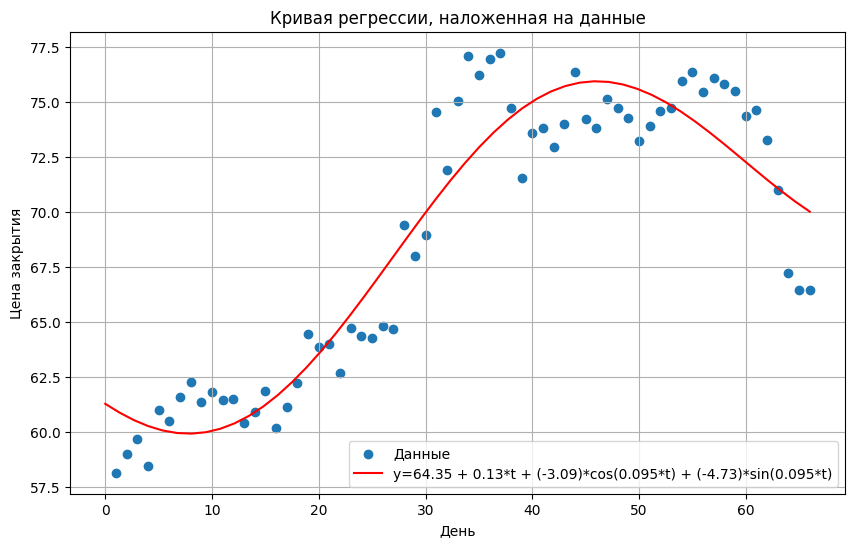

In [ ]:
# Изображение данных на графике
plt.figure(figsize=(10, 6))
plt.scatter(train_X, train_Y, label='Данные')
plt.title('Кривая регрессии, наложенная на данные')
plt.xlabel('День')
plt.ylabel('Цена закрытия')
plt.grid(True)
# Построение кривой регрессии на графике
x = np.linspace(0, len(train_X))
y_line = y_model(x, B)
plt.plot(x, y_line, 'r-', label=f'y={round(B[0], 2)} + {round(B[1], 2)}*t + ({round(B[2], 2)})*cos({round(frequencies[0], 3)}*t) + ({round(B[3], 2)})*sin({round(frequencies[0], 3)}*t)')
plt.legend()

Далее будем добавлять гармоники в модель до тех пор, пока оба новых параметра не окажутся незначимыми (или пока не закончатся частоты).

1) **6 параметров**

In [ ]:
B, K = lin_harmonic_reg_params(train_X, train_Y, frequencies, 6)
show_info(train_X, train_Y, B, K)

Оценка коэффициента детерминации: 0.9466472683936041

F-статистика Фишера: 212.9181932900593 (наблюдаемый уровень значимости: 1.1102230246251565e-16)

Оценка остаточной дисперсии модели квадратичной регрессии: 2.31135649663652



,Параметр,Значение,t-статистика,Уровень значимости,Параметр значим
0,a0,64.823649,106.593784,0.000000e+00,True
1,a1,0.118236,6.845325,4.589573e-09,True
2,b1,-3.075002,-11.594339,0.000000e+00,True
3,c1,-5.030865,-11.206977,2.220446e-16,True
4,b2,-1.931360,-7.282218,8.249577e-10,True
5,c2,-0.853653,-2.937127,4.692996e-03,True


2) **8 параметров**

In [ ]:
B, K = lin_harmonic_reg_params(train_X, train_Y, frequencies, 8)
show_info(train_X, train_Y, B, K)

Оценка коэффициента детерминации: 0.9725983393001494

F-статистика Фишера: 294.09429021377423 (наблюдаемый уровень значимости: 1.1102230246251565e-16)

Оценка остаточной дисперсии модели квадратичной регрессии: 1.2280340714545366



,Параметр,Значение,t-статистика,Уровень значимости,Параметр значим
0,a0,64.780437,140.941557,0.000000e+00,True
1,a1,0.119526,9.122664,8.326673e-13,True
2,b1,-3.076292,-15.910359,0.000000e+00,True
3,c1,-5.003787,-14.894371,0.000000e+00,True
4,b2,-1.932649,-9.995521,3.153033e-14,True
5,c2,-0.844682,-3.959179,2.079155e-04,True
6,b3,-1.404651,-7.264754,1.052299e-09,True
7,c3,-0.267298,-1.334327,1.873121e-01,False


3) **10 параметров**

In [ ]:
B, K = lin_harmonic_reg_params(train_X, train_Y, frequencies, 10)
show_info(train_X, train_Y, B, K)

Оценка коэффициента детерминации: 0.9762801676630305

F-статистика Фишера: 256.09928721460153 (наблюдаемый уровень значимости: 1.1102230246251565e-16)

Оценка остаточной дисперсии модели квадратичной регрессии: 1.1009944086231032



,Параметр,Значение,t-статистика,Уровень значимости,Параметр значим
0,a0,65.691485,108.061167,0.000000e+00,True
1,a1,0.092330,5.206899,2.841507e-06,True
2,b1,-3.049097,-16.614937,0.000000e+00,True
3,c1,-5.574690,-13.444478,0.000000e+00,True
4,b2,-1.905454,-10.383074,1.154632e-14,True
5,c2,-1.033831,-4.690809,1.792213e-05,True
6,b3,-1.377456,-7.505942,5.046619e-10,True
7,c3,-0.379400,-1.928445,5.887510e-02,False
8,b4,0.420779,2.292880,2.563272e-02,True
9,c4,-0.522764,-2.006951,4.959150e-02,True


4) **12 параметров**

In [ ]:
B, K = lin_harmonic_reg_params(train_X, train_Y, frequencies, 12)
show_info(train_X, train_Y, B, K)

Оценка коэффициента детерминации: 0.9772781909957295

F-статистика Фишера: 211.14284880082695 (наблюдаемый уровень значимости: 1.1102230246251565e-16)

Оценка остаточной дисперсии модели квадратичной регрессии: 1.0937313751556172



,Параметр,Значение,t-статистика,Уровень значимости,Параметр значим
0,a0,65.460498,93.296529,0.000000e+00,True
1,a1,0.099225,4.819354,1.210897e-05,True
2,b1,-3.055992,-16.679927,0.000000e+00,True
3,c1,-5.429943,-11.577918,2.220446e-16,True
4,b2,-1.912349,-10.437803,1.465494e-14,True
5,c2,-0.985874,-4.256367,8.330504e-05,True
6,b3,-1.384351,-7.555934,5.157130e-10,True
7,c3,-0.350978,-1.747345,8.626236e-02,False
8,b4,0.413884,2.259021,2.794217e-02,True
9,c4,-0.450555,-1.596609,1.161890e-01,False


Получили, что при добавлении пятой пары оба новых параметра оказались незначимыми. Значит, возвращаемся к предыдущей модели.

In [ ]:
B, K = lin_harmonic_reg_params(train_X, train_Y, frequencies, 10)
show_info(train_X, train_Y, B, K)

Оценка коэффициента детерминации: 0.9762801676630305

F-статистика Фишера: 256.09928721460153 (наблюдаемый уровень значимости: 1.1102230246251565e-16)

Оценка остаточной дисперсии модели квадратичной регрессии: 1.1009944086231032



,Параметр,Значение,t-статистика,Уровень значимости,Параметр значим
0,a0,65.691485,108.061167,0.000000e+00,True
1,a1,0.092330,5.206899,2.841507e-06,True
2,b1,-3.049097,-16.614937,0.000000e+00,True
3,c1,-5.574690,-13.444478,0.000000e+00,True
4,b2,-1.905454,-10.383074,1.154632e-14,True
5,c2,-1.033831,-4.690809,1.792213e-05,True
6,b3,-1.377456,-7.505942,5.046619e-10,True
7,c3,-0.379400,-1.928445,5.887510e-02,False
8,b4,0.420779,2.292880,2.563272e-02,True
9,c4,-0.522764,-2.006951,4.959150e-02,True


Таким образом, результирующая модель имеет вид:

$$
y(t) = 65.691485 + 0.092330\,t \\
+ (-3.049097)\cos(0.095200 * t) + (-5.574690)\sin(0.095200 * t) \\
+ (-1.905454)\cos(0.285599 * t) + (-1.033831)\sin(0.285599 * t) \\
+ (-1.377456)\cos(0.475999 * t) + (-0.379400)\sin(0.475999 * t) \\
+ (+0.420779)\cos(0.190400 * t) + (-0.522764)\sin(0.190400 * t)
$$


Данная модель имеет высокий коэффициент детерминации, близкий к 1.

Модель значима (с запасом) и все её коэффициенты значимы, кроме c3, который остается, поскольку b3 - значим.

В результате, в линейную модель были включены следующие гармоники: 1, 3, 5, 2.

Посмотрим на график данной модели.

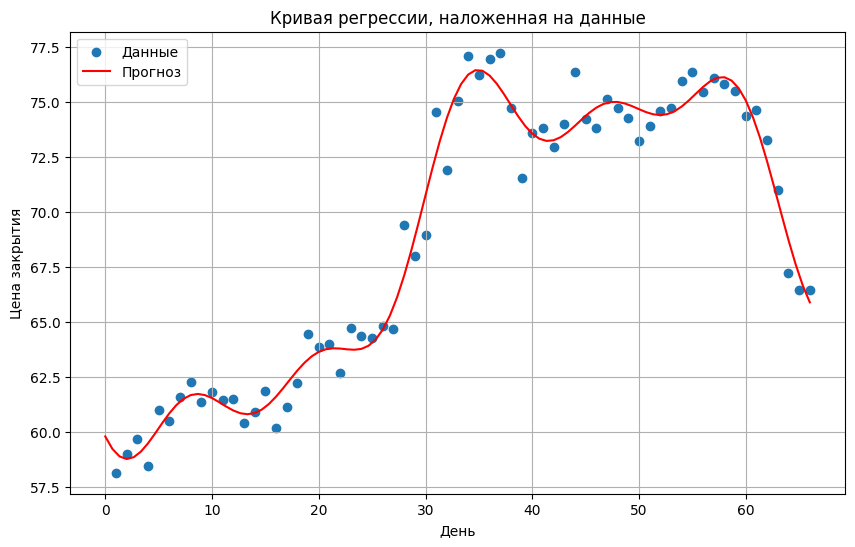

In [ ]:
# Изображение данных на графике
plt.figure(figsize=(10, 6))
plt.scatter(train_X, train_Y, label='Данные')
plt.title('Кривая регрессии, наложенная на данные')
plt.xlabel('День')
plt.ylabel('Цена закрытия')
plt.grid(True)
# Построение кривой регрессии на графике
x = np.linspace(0, len(train_X), 100)
y_line = y_model(x, B)
plt.plot(x, y_line, 'r-', label='Прогноз')
plt.legend()

In [ ]:
# Запишем характеристики результирующей модели в соответствующие переменные
R_2, F, s_2, t_vec, n, k = model_info(train_X, train_Y, B, K)

**2. Статистический анализ остатков модели**

1) Проверка гипотезы о независимости остатков

**Критерий Дарбина-Уотсона** используется для проверки на автокорреляцию первого порядка (т. е. на взаимозависимость соседних остатков).

**Определение статистики DW**

Обозначим остатки регрессионной модели как $e_1, e_2, \ldots, e_n$. Тогда статистика Дарбина-Уотсона:

$$
DW = \frac{\sum_{t=2}^n (e_t - e_{t-1})^2}{\sum_{t=1}^n e_t^2}
$$

Числитель можно представить как:

$$
\begin{aligned}
\sum_{t=2}^n (e_t - e_{t-1})^2 &= \sum_{t=2}^n e_t^2 + \sum_{t=2}^n e_{t-1}^2 - 2\sum_{t=2}^n e_t e_{t-1} = 2\sum_{t=1}^n e_t^2 - e_1^2 - e_n^2 - 2\sum_{t=2}^n e_t e_{t-1}
\end{aligned}
$$

При большом $n$ крайними членами можно пренебречь, тогда:

$$
DW \approx 2(1 - \hat{\rho}_1)
$$

где оценка автокорреляции первого порядка:

$$
\hat{\rho}_1 = \frac{\sum_{t=2}^n e_t e_{t-1}}{\sum_{t=1}^n e_t^2}
$$

**Интерпретация результата:**

- (0 ≤ DW < dₗ): Положительная автокорреляция (H₀ отвергается, принимается H₁: ρ > 0)
- (dₗ ≤ DW ≤ dᵤ): Неопределенность (недостаточно данных для вывода)
- (dᵤ < DW < 4-dᵤ): Автокорреляция отсутствует (H₀ принимается)
- (4-dᵤ ≤ DW ≤ 4-dₗ): Неопределенность (недостаточно данных для вывода)
- (4-dₗ < DW ≤ 4): Отрицательная автокорреляция (H₀ отвергается, принимается H₁: ρ < 0)


При уровне значимости $ \alpha $ = 0.05, одном регрессоре и n = 66:

$d_{u}$ = 1.63,

$d_{l}$ = 1.57.

In [ ]:
# Вектор остатков результирующей модели
residuals = np.array([train_Y[i] - y_model(train_X[i], B) for i in range(len(train_Y))])

In [ ]:
dw_stat = durbin_watson(residuals)
print(f"Статистика Дарбина-Уотсона: {dw_stat:.4f}")

Статистика Дарбина-Уотсона: 2.1971


$$
1.63 < 2.1971 < 2.37 => \text{Автокорреляция отсутствует, остатки независимы}
$$

2) Проверка гипотезы о гомоскедастичности остатков

**Тест Голдфелда-Квандта**

Гипотезы:      
*   H0: гомоскедастичность (ошибки имеют одинаковую дисперсию)
*   H1: гетероскедастичность (дисперсия ошибок различается)

Алгоритм:   
*   Отсортировать наблюдения по значению одного из признаков (обычно предположительно связанного с дисперсией).
*   Удалить центральную часть выборки (для лучшего различия).
*   Разбить оставшиеся наблюдения на две группы.      Построить регрессию на каждой группе.
*   Рассчитать отношение дисперсий остатков (F-статистика).

1. Оценка остаточной дисперсии:
$$s_i^2 = \frac{RSS_i}{n_i - k}, \quad i = 1, 2$$
где:
- $RSS_i$ — сумма квадратов остатков в группе
- $n_i$ — число наблюдений в группе
- $k$ — число параметров модели

2. F-статистика:
$$F = \frac{\max(s_1^2, s_2^2)}{\min(s_1^2, s_2^2)}$$
При $H_0$:  $F \sim F(n_{max}-k, n_{min}-k)$


In [ ]:
# Удалим центральные 20% данных
drop_count = n // 5
train_X_1 = train_X[:(n-drop_count) // 2]
train_Y_1 = train_Y[:(n-drop_count) // 2]
train_X_2 = train_X[-(n-drop_count) // 2 :]
train_Y_2 = train_Y[-(n-drop_count) // 2 :]

# Параметры первой модели
B_1, _ = lin_harmonic_reg_params(train_X_1, train_Y_1, frequencies, 10)

# Параметры второй модели
B_2, _ = lin_harmonic_reg_params(train_X_2, train_Y_2, frequencies, 10)

# Вектор остатков первой модели
residuals_1 = np.array([train_Y_1[i] - y_model(train_X_1[i], B_1) for i in range(len(train_Y_1))])

# Вектор остатков второй модели
residuals_2 = np.array([train_Y_2[i] - y_model(train_X_2[i], B_2) for i in range(len(train_Y_2))])

s1_sq = np.sum(residuals_1**2)/(len(train_Y_1) - len(B_1))
s2_sq = np.sum(residuals_2**2)/(len(train_Y_2) - len(B_2))

F_stat = s1_sq/s2_sq

# Критическое значение
F_crit = f.ppf(0.95, dfn=(len(train_Y_1) - len(B_1)), dfd=(len(train_Y_2) - len(B_2)))

if F_stat < F_crit:
  print('H0 принимается, остатки гомоскедастичны.')
else:
  print('Принимается H1, остатки гетероскедастичны.')

H0 принимается, остатки гомоскедастичны.


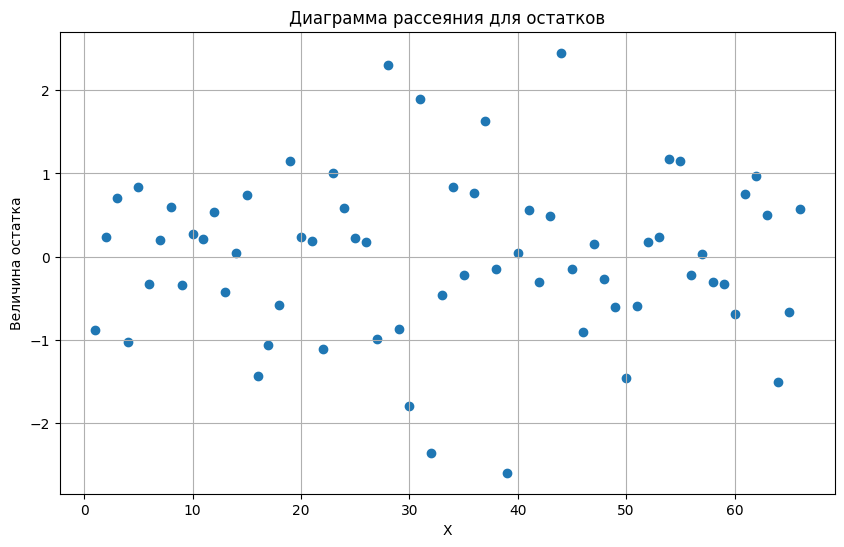

In [ ]:
# Отображение диаграммы рассеяния остатков
plt.figure(figsize=(10, 6))
plt.scatter(train_X, residuals)
plt.title('Диаграмма рассеяния для остатков')
plt.xlabel('X')
plt.ylabel('Величина остатка')
plt.grid(True)

Из диаграммы рассеяния также видно, что остатки модели - гомоскедастичны.

3) Проверка гипотезы о нормальности распределения остатков

**Критерий Шапиро-Уилка**

Алгоритм проверки нормальности остатков:

1. Собрать остатки модели $\{r_i\}_{i=1}^n$
2. Отсортировать по возрастанию: $r_{(1)} \leq \cdots \leq r_{(n)}$
3. Вычислить:
   - Выборочное среднее $\bar{r} = \frac{1}{n}\sum r_i$
   - Сумму квадратов отклонений $SS = \sum (r_i - \bar{r})^2$
4. Взять коэффициенты $a_i$ для данного $n$ (из таблиц)
   
   Коэффициенты вычисляются как:
   $$
   \mathbf{a} = \frac{V^{-1}\mathbf{m}}{||V^{-1}\mathbf{m}||}
   $$
   где:
   - Вектор m = (m₁,...,mₙ) — матожидания упорядоченных статистик из стандартного нормального распределения;
   - V⁻¹ — обратная матрица ковариаций.
5. Рассчитать статистику:
   $$W = \frac{\left(\sum_{i=1}^n a_i r_{(i)}\right)^2}{SS}$$
6. Найти $p$-value по $(W, n)$
7. Сравнить с $\alpha=0.05$:
   - $p < \alpha$ → отвергаем $H_0$ (не нормальны)
   - $p \geq \alpha$ → нет оснований отвергать $H_0$




In [ ]:
W_statistic, p_value = shapiro(residuals)

print(f"Статистика W = {W_statistic:.4f}")
print(f"p-value = {p_value:.4f}", end='\n\n')

if p_value < 0.05:
    print("Принимается H1: остатки ненормальны.")
else:
    print("Принимается H0: гипотеза о нормальности остатков модели.")

Статистика W = 0.9858
p-value = 0.6531

Принимается H0: гипотеза о нормальности остатков модели.


Также рассмотрим гистограмму остатков.

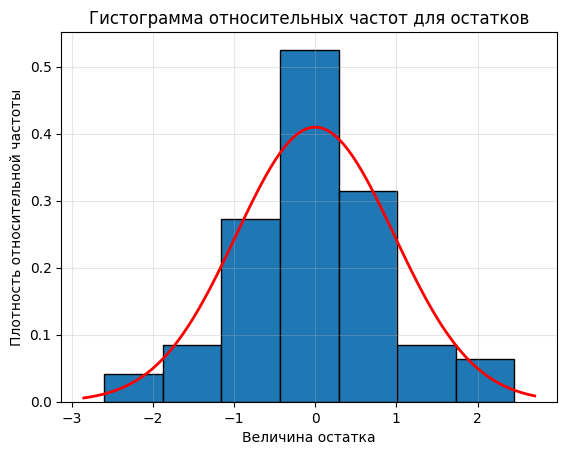

In [ ]:
# Найдем оценки параметров нормального распределения
res_mean = sum(residuals)/len(residuals)
res_disp = sum([(residuals[i] - res_mean)**2 for i in range(len(residuals))])/(len(residuals)-1)

# Построение гистограммы
plt.hist(residuals, bins=int(1 + np.log2(len(residuals))), density=True, edgecolor='black')
plt.title('Гистограмма относительных частот для остатков')
plt.xlabel('Величина остатка')
plt.ylabel('Плотность относительной частоты')
plt.grid(True, alpha=0.3)

# Наложение графика плотности нормального распределения
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, res_mean, res_disp**0.5)
plt.plot(x, p, 'r', linewidth=2)

Как можно видеть из наложения кривой плотности нормального распределения на гистограмму, распределение величины остатка похоже на нормальное.

Таким образом, все предположения регрессионного анализа об остатках (независимость, гомоскедастичность и нормальность) выполняются.

**3. Использование модели для прогнозирования, построение доверительных границ для прогноза**

В условиях рассматриваемой задачи, целью является прогноз на 4 дня вперёд.

Доверительный интервал для цен закрытия в точке $x$ уровня $\beta = 1 - \alpha$:

$(\hat{y}(x) - \delta(x); \hat{y}(x) + \delta(x))$, где

$\delta(x) = \tau_{1-\alpha/2} \sqrt{s^2 (\phi^T(x) K^{-1} \phi(x) + 1)}$,

и $\tau_{1-\alpha/2}$ - квантиль Стьюдента уровня $1-\alpha/2$ с $n-k-1$ степенями свободы.

In [ ]:
# Нахождение границ доверительного интервала уровня 0,95 для линии линейной регрессии в точке x
def conf_int(x):
  tau = t.ppf(0.975, df=n-k-1)
  phi_vec = np.array([1, x, np.cos(0.0952*x), np.sin(0.0952*x),
                      np.cos(0.285599*x), np.sin(0.285599*x),
                      np.cos(0.475999*x), np.sin(0.475999*x),
                      np.cos(0.1904*x), np.sin(0.1904*x)])
  delta = tau*(s_2*(phi_vec.T @ np.linalg.inv(K) @ phi_vec + 1))**0.5
  return delta

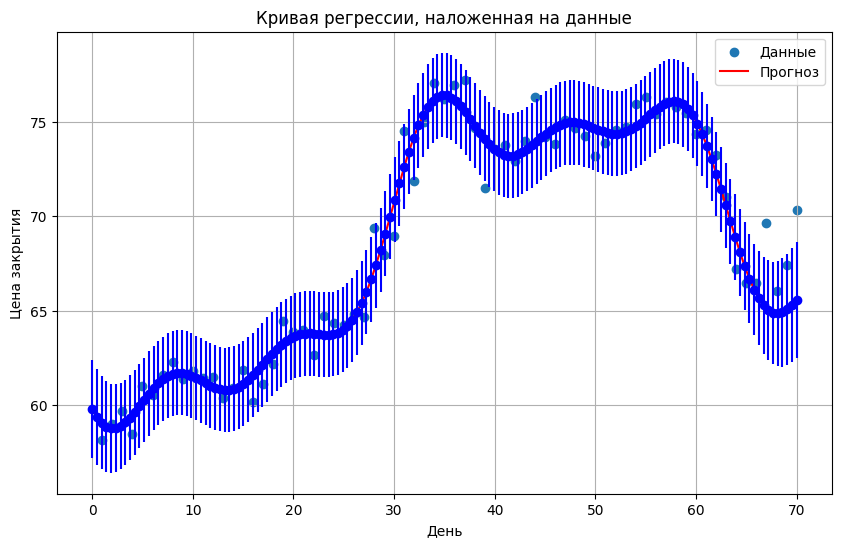

In [ ]:
# Объединим тренировочную и тестовую выборки для наглядности
X = np.concatenate((train_X, test_X))
Y = np.concatenate((train_Y, test_Y))

# Изображение данных на графике
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='Данные')
plt.title('Кривая регрессии, наложенная на данные')
plt.xlabel('День')
plt.ylabel('Цена закрытия')
plt.grid(True)
# Построение кривой регрессии на графике
x = np.linspace(0, len(X), 150)
y_line = y_model(x, B)
plt.plot(x, y_line, 'r-', label='Прогноз')
plt.errorbar(x, y_line, yerr=[conf_int(arg) for arg in x], fmt='o', color='blue')
plt.legend()

Построим также таблицу с прогнозными данными и реальными значениями.

In [ ]:
real_pred_df = pd.DataFrame({'Реальная цена': test_Y, 'Прогноз': [y_model(x, B) for x in test_X]})
real_pred_df

,Реальная цена,Прогноз
0,69.63,65.108932
1,66.02,64.847315
2,67.43,65.036767
3,70.36,65.555822


В результате, одно значение чётко попадает в 95%-й доверительный интервал, одно находится на границе и два не попадают в него. В 4 дня, для которых строится прогноз, произошел резкий скачок в цене акций. Однако модель хорошо описывает динамику цены в целом.

**Выводы**

В ходе выполнения курсовой работы было проведено исследование динамики цен акций Аэрофлота (AFLT) на Московской бирже за период с 01.01.2025-31.03.2025.
В результате, с применением спектрального анализа, была построена линейная модель с гармонической составляющей. Модель оказалась значимой и имела очень высокий коэффициент детерминации. Было проведено исследование остатков модели с применением критериев Дарбина-Уотсона, Голдфелда-Квандта и Шапиро-Уилка, в ходе которого было выяснено, что остатки полностью удовлетворяют предположениям регрессионного анализа.

Построенная модель была использована для прогнозирования цен акций на 4 дня вперёд. Две цены из четырёх попали в 95%-й доверительный интервал, тем не менее, две другие - нет. Объясняется это тем, что именно в эти дни произошел резкий скачок цен акций, однако, модель уловила общий тренд на начало роста в это время. Таким образом, была получена модель, пригодная для анализа ситуации на рынке и краткосрочного прогнозирования.